<a href="https://colab.research.google.com/github/ranim-missaoui/Tunisian-used-car-prices-prediction/blob/main/BOXCOX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving tunisian_cars_dataset.xlsx to tunisian_cars_dataset.xlsx


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [22]:
df = pd.read_excel("tunisian_cars_dataset.xlsx")
df.head(25)
df.describe()

,Age,Engine_size,HP,Mileage in KM,price in DT
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,6.791506,1.623359,8.668919,117326.831081,101823.296332
std,4.563769,0.587071,4.659979,81283.029309,75304.774073
min,0.000000,0.900000,4.000000,0.000000,19900.000000
25%,4.000000,1.300000,6.000000,60000.000000,51000.000000
50%,5.500000,1.500000,8.000000,100000.000000,78000.000000
75%,9.000000,1.600000,9.000000,158000.000000,128000.000000
max,34.000000,6.100000,43.000000,670800.000000,570000.000000


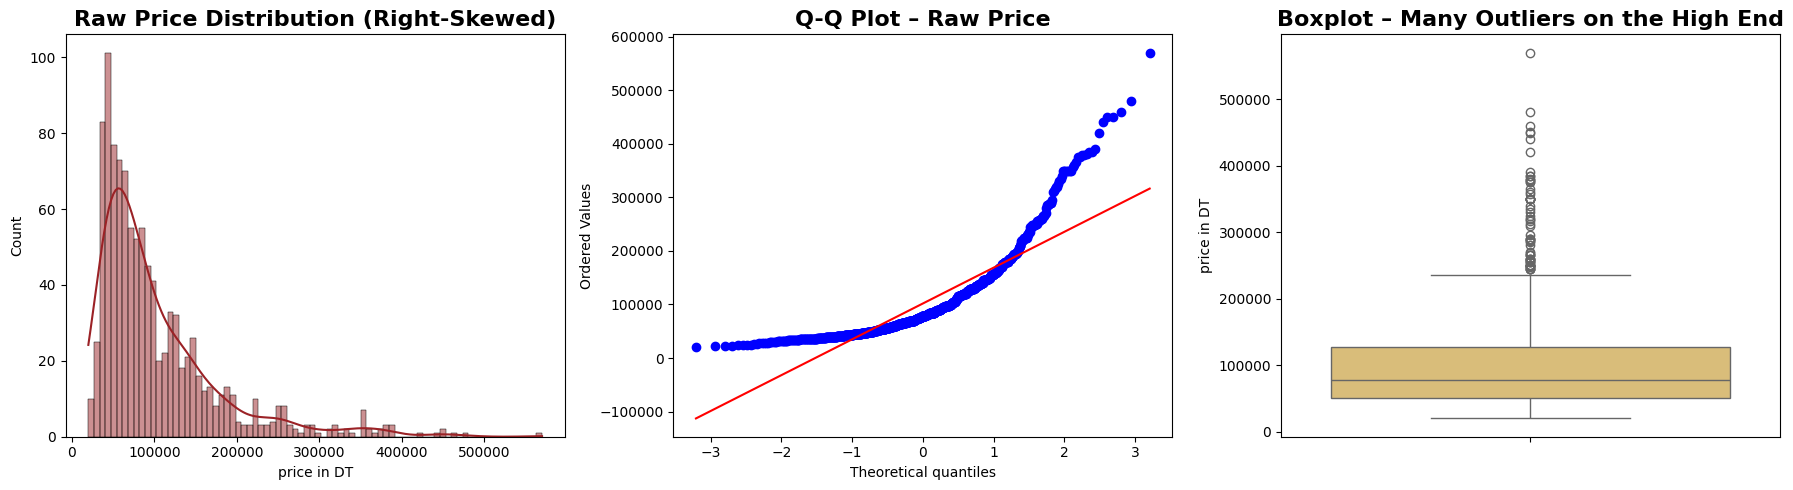

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df['price in DT'], bins=80, kde=True, ax=axes[0], color='#9b2226')
axes[0].set_title('Raw Price Distribution (Right-Skewed)', fontsize=16, fontweight='bold')

stats.probplot(df['price in DT'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot – Raw Price', fontsize=16, fontweight='bold')

sns.boxplot(y=df['price in DT'], ax=axes[2], color='#e9c46a')
axes[2].set_title('Boxplot – Many Outliers on the High End', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Optimal λ = -0.326


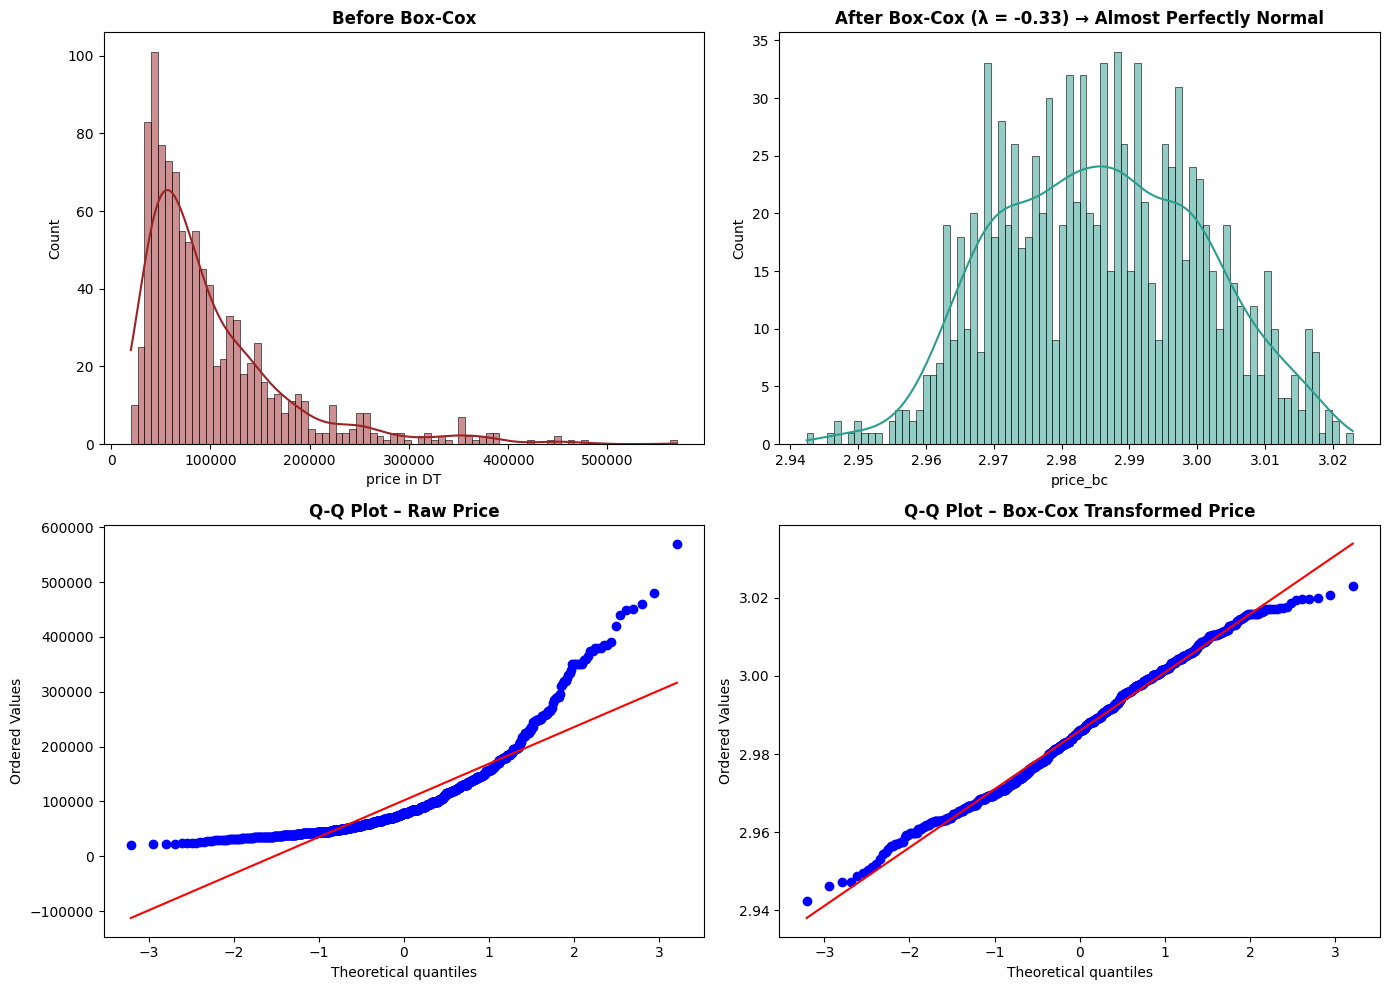

In [12]:
price_shifted = df['price in DT'] + 1          # safe
price_bc, lmbda = stats.boxcox(price_shifted)

print(f"Optimal λ = {lmbda:.3f}")

df['price_bc'] = price_bc

# Before vs After
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Histograms
sns.histplot(df['price in DT'], bins=80, kde=True, ax=axes[0,0], color='#9b2226')
axes[0,0].set_title('Before Box-Cox', fontweight='bold')

sns.histplot(df['price_bc'], bins=80, kde=True, ax=axes[0,1], color='#2a9d8f')
axes[0,1].set_title(f'After Box-Cox (λ = {lmbda:.2f}) → Almost Perfectly Normal', fontweight='bold')

# Q-Q plots
stats.probplot(df['price in DT'], dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot – Raw Price', fontweight='bold')

stats.probplot(df['price_bc'], dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot – Box-Cox Transformed Price', fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
df = pd.get_dummies(df, drop_first=True)

feature_cols = [col for col in df.columns if col not in ['price in DT', 'price_bc']]
X = df[feature_cols]
y_raw = df['price in DT']
y_bc = df['price_bc']

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)
_, _, y_train_bc, y_test_bc = train_test_split(X, y_bc, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

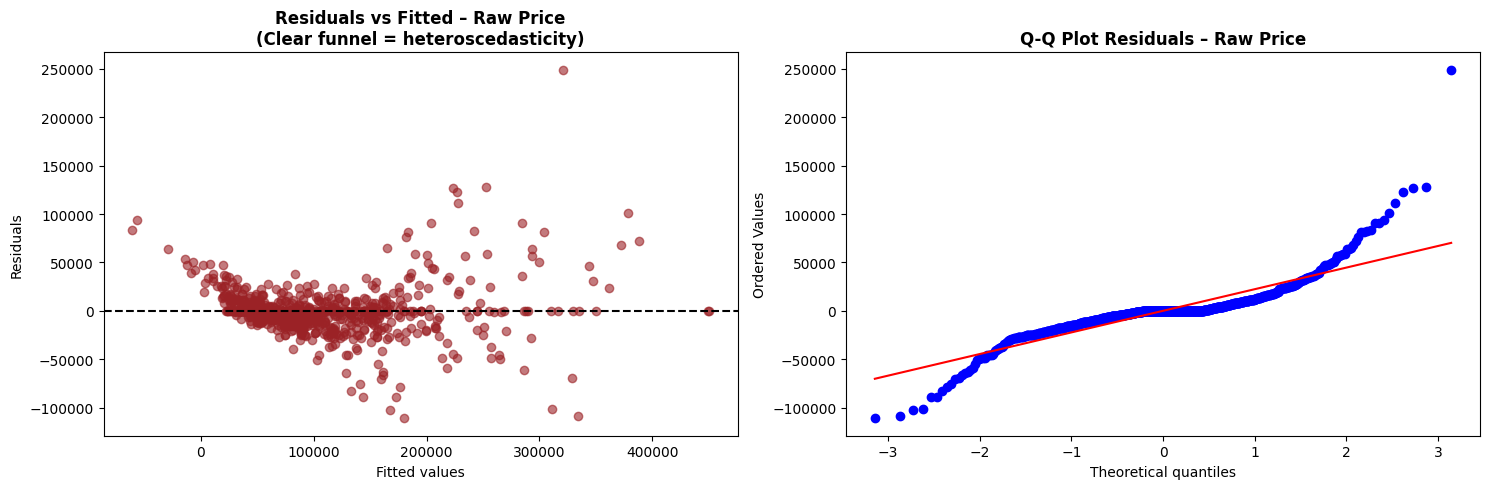

In [14]:
ols_raw = LinearRegression().fit(X_train, y_train_raw)
pred_raw = ols_raw.predict(X_train)
resid_raw = y_train_raw - pred_raw

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(pred_raw, resid_raw, alpha=0.6, color='#9b2226')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted – Raw Price\n(Clear funnel = heteroscedasticity)', fontweight='bold')

stats.probplot(resid_raw, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot Residuals – Raw Price', fontweight='bold')
plt.tight_layout()
plt.show()

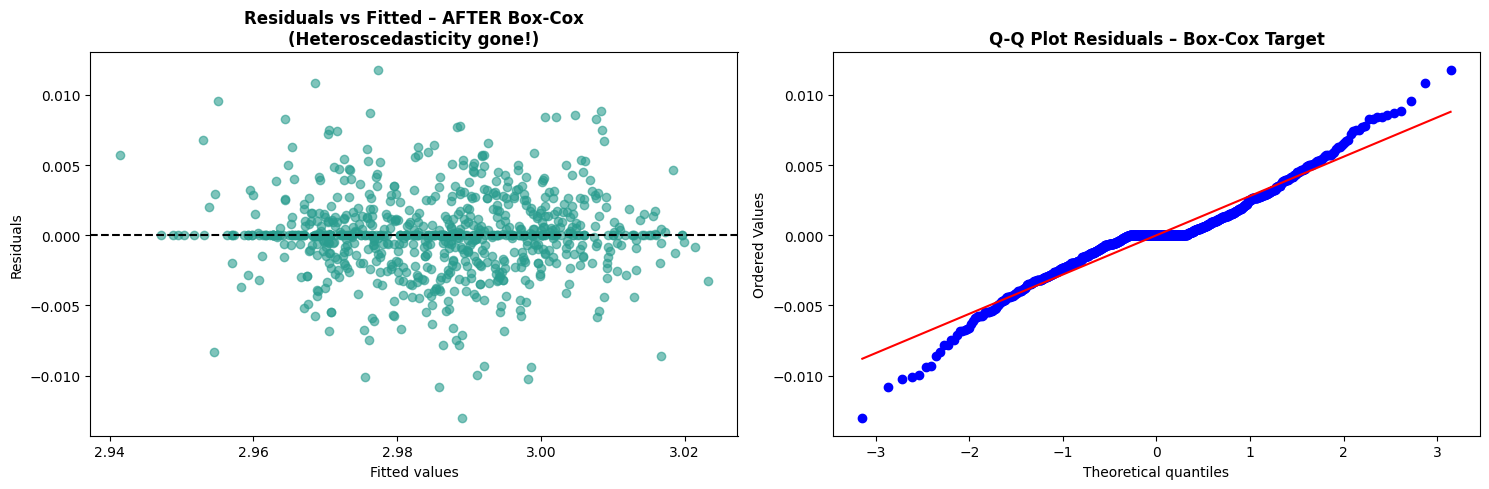

In [15]:
ols_bc = LinearRegression().fit(X_train_scaled, y_train_bc)
pred_bc = ols_bc.predict(X_train_scaled)
resid_bc = y_train_bc - pred_bc

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].scatter(pred_bc, resid_bc, alpha=0.6, color='#2a9d8f')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted – AFTER Box-Cox\n(Heteroscedasticity gone!)', fontweight='bold')

stats.probplot(resid_bc, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot Residuals – Box-Cox Target', fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
ridge = RidgeCV(alphas=np.logspace(-2, 4, 50), cv=5).fit(X_train_scaled, y_train_bc)
lasso = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, max_iter=20000, random_state=42).fit(X_train_scaled, y_train_bc)
elastic = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
                       alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000).fit(X_train_scaled, y_train_bc)

models = {
    "OLS (raw)": LinearRegression().fit(X_train, y_train_raw),
    "OLS (Box-Cox)": LinearRegression().fit(X_train_scaled, y_train_bc),
    "Ridge": ridge,
    "Lasso": lasso,
    "Elastic Net": elastic
}

X_test_dict = {
    "OLS (raw)": X_test,
    "OLS (Box-Cox)": X_test_scaled,
    "Ridge": X_test_scaled,
    "Lasso": X_test_scaled,
    "Elastic Net": X_test_scaled
}

y_test_dict = {
    "OLS (raw)": y_test_raw,
    "OLS (Box-Cox)": y_test_bc,
    "Ridge": y_test_bc,
    "Lasso": y_test_bc,
    "Elastic Net": y_test_bc
}

In [18]:
from scipy.special import inv_boxcox

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_dict[name])

    # Inverse Box-Cox for interpretable MAE
    if "OLS (raw)" in name:
        y_pred_inv = y_pred
        y_test_inv = y_test_dict[name]
    else:
        y_pred_inv = inv_boxcox(y_pred, lmbda) - 1   # reverse the +1 we did
        y_test_inv = inv_boxcox(y_test_dict[name], lmbda) - 1

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    n_features = np.sum(np.abs(model.coef_) > 1e-5) if hasattr(model, "coef_") else len(model.coef_)

    results.append({
        "Model": name,
        "R²": round(r2, 3),
        "MAE (TND)": f"{mae:,.0f}",
        "# Features": n_features
    })

results_df = pd.DataFrame(results)
results_df

,Model,R²,MAE (TND),# Features
0,OLS (raw),0.803,"23,540",361
1,OLS (Box-Cox),0.915,"13,753",358
2,Ridge,0.893,"14,638",355
3,Lasso,0.771,"17,510",249
4,Elastic Net,0.825,"16,325",272


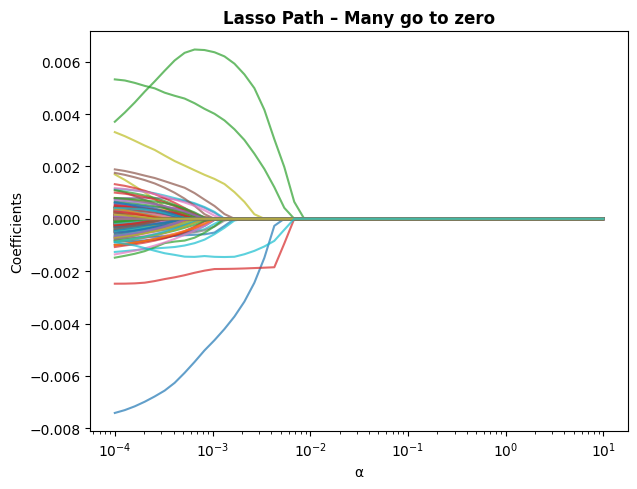

In [20]:
alphas_lasso, coefs_lasso, _ = lasso.path(X_train_scaled, y_train_bc, alphas=np.logspace(-4,1,50))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i], alpha=0.7)
plt.xscale('log')
plt.xlabel('α')
plt.ylabel('Coefficients')
plt.title('Lasso Path – Many go to zero', fontweight='bold')


plt.tight_layout()
plt.show()

In [21]:
print("YOUR FINAL SLIDE TABLE")
display(results_df.style.background_gradient(cmap='RdYlGn'))

YOUR FINAL SLIDE TABLE


,Model,R²,MAE (TND),# Features
0,OLS (raw),0.803000,"23,540",361
1,OLS (Box-Cox),0.915000,"13,753",358
2,Ridge,0.893000,"14,638",355
3,Lasso,0.771000,"17,510",249
4,Elastic Net,0.825000,"16,325",272
